## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.pipeline import Pipeline
import joblib
import pickle
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load and Prepare Data

In [2]:
data = pd.read_csv("Real Estate Data V21.csv")
print(f"   Dataset Overview:")
print(f"   Shape: {data.shape}")
print(f"   Columns: {list(data.columns)}")
print(f"   Missing values: {data.isnull().sum().sum()}")
print(f"   Duplicates: {data.duplicated().sum()}")
print(f"\n Sample Data:")
data.head()

   Dataset Overview:
   Shape: (14528, 9)
   Columns: ['Name', 'Property Title', 'Price', 'Location', 'Total_Area', 'Price_per_SQFT', 'Description', 'Baths', 'Balcony']
   Missing values: 0
   Duplicates: 8

 Sample Data:


,Name,Property Title,Price,Location,Total_Area,Price_per_SQFT,Description,Baths,Balcony
0,Casagrand ECR 14,"4 BHK Flat for sale in Kanathur Reddikuppam, C...",₹1.99 Cr,"Kanathur Reddikuppam, Chennai",2583,7700.0,Best 4 BHK Apartment for modern-day lifestyle ...,4,Yes
1,"Ramanathan Nagar, Pozhichalur,Chennai",10 BHK Independent House for sale in Pozhichal...,₹2.25 Cr,"Ramanathan Nagar, Pozhichalur,Chennai",7000,3210.0,Looking for a 10 BHK Independent House for sal...,6,Yes
2,DAC Prapthi,"3 BHK Flat for sale in West Tambaram, Chennai",₹1.0 Cr,"Kasthuribai Nagar, West Tambaram,Chennai",1320,7580.0,"Property for sale in Tambaram, Chennai. This 3...",3,No
3,"Naveenilaya,Chepauk, Triplicane,Chennai",7 BHK Independent House for sale in Triplicane...,₹3.33 Cr,"Naveenilaya,Chepauk, Triplicane,Chennai",4250,7840.0,Entire Building for sale with 7 units of singl...,5,Yes
4,VGN Spring Field Phase 1,"2 BHK Flat for sale in Avadi, Chennai",₹48.0 L,"Avadi, Chennai",960,5000.0,"Property for sale in Avadi, Chennai. This 2 BH...",3,Yes


## 3. Feature Engineering Pipeline

In [3]:
import importlib
import sys
if 'feature_engineering' in sys.modules:
    importlib.reload(sys.modules['feature_engineering'])
from feature_engineering import RealEstateFeatureEngineer

print(" RealEstateFeatureEngineer RELOADED from feature_engineering module!")
print(" This ensures the LATEST feature engineering logic is used!")
print(" The class now uses EXACT Multiple Algorithms preprocessing!")

 RealEstateFeatureEngineer class loaded from feature_engineering module!
 RealEstateFeatureEngineer RELOADED from feature_engineering module!
 This ensures the LATEST feature engineering logic is used!
 The class now uses EXACT Multiple Algorithms preprocessing!


## 4. Create Complete ML Pipeline

In [4]:
print(" Initializing Real Estate Price Prediction Pipeline with sklearn Pipeline...")

feature_engineer = RealEstateFeatureEngineer()

bagging_model = BaggingRegressor(
    n_estimators=15,
    max_samples=0.6,
    max_features=0.6,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline([
    ('feature_engineer', feature_engineer),
    ('model', bagging_model)
])

print("    sklearn Pipeline initialized with optimized Bagging Regressor!")
print(f"   Pipeline Components:")
print(f"   Feature Engineer: {type(pipeline.named_steps['feature_engineer']).__name__}")
print(f"   Model: {type(pipeline.named_steps['model']).__name__}")
print(f"   Model Parameters: {pipeline.named_steps['model'].get_params()}")

 Initializing Real Estate Price Prediction Pipeline with sklearn Pipeline...
    sklearn Pipeline initialized with optimized Bagging Regressor!
   Pipeline Components:
   Feature Engineer: RealEstateFeatureEngineer
   Model: BaggingRegressor
   Model Parameters: {'bootstrap': True, 'bootstrap_features': False, 'estimator': None, 'max_features': 0.6, 'max_samples': 0.6, 'n_estimators': 15, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


## 5. Train the Final Model

In [5]:
print(" TRAINING PRODUCTION PIPELINE")


temp_feature_engineer = RealEstateFeatureEngineer()
temp_feature_engineer.fit(data)
y_all = temp_feature_engineer.get_target(data)
data_aligned = data.loc[y_all.index]

print(f"   Training Data:")
print(f"   Features: {data.shape[1]} input columns")
print(f"   Samples: {len(data)} total, {len(data_aligned)} after cleaning")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    data_aligned, y_all,
    test_size=0.2,
    random_state=42,
    stratify=data_aligned['City'] if 'City' in data_aligned.columns else None
)

print(f"   Train samples: {len(X_train_raw)}, Test samples: {len(X_test_raw)}")

pipeline.fit(X_train_raw, y_train)


from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
y_train_pred = pipeline.predict(X_train_raw)
y_test_pred = pipeline.predict(X_test_raw)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"   TRUE Model Performance (No Data Leakage):")
print(f"   Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
print(f"   Overfitting Gap: {((train_r2 - test_r2) / train_r2 * 100):.1f}%")

# Store these for the evaluation cell
global X_train_global, X_test_global, y_train_global, y_test_global
X_train_global, X_test_global = X_train_raw, X_test_raw  
y_train_global, y_test_global = y_train, y_test

 TRAINING PRODUCTION PIPELINE
 Fitting Feature Engineering Pipeline (Multiple Algorithms Method)...
   Applying outlier removal...
     Removed 2641 outliers (18.2%)
 Feature Engineering Pipeline fitted with Multiple Algorithms method!
   Training Data:
   Features: 9 input columns
   Samples: 14528 total, 11879 after cleaning
   Train samples: 9503, Test samples: 2376
 Fitting Feature Engineering Pipeline (Multiple Algorithms Method)...
   Applying outlier removal...
     Removed 985 outliers (10.4%)
 Feature Engineering Pipeline fitted with Multiple Algorithms method!
 Transforming data...
 Transformed data shape: (9503, 18)
 Transforming data...
 Transformed data shape: (9503, 18)
 Transforming data...
 Transformed data shape: (2376, 18)
   TRUE Model Performance (No Data Leakage):
   Train R²: 0.9180, Test R²: 0.8496
   Overfitting Gap: 7.5%


## 6. Model Evaluation and Validation

 COMPREHENSIVE MODEL EVALUATION
   Using same train/test split from training:
   Train samples: 9503, Test samples: 2376
 Transforming data...
 Transformed data shape: (9503, 18)
 Transforming data...
 Transformed data shape: (2376, 18)
    PERFORMANCE METRICS:
   Train R²: 0.9180 (91.8%)
   Test R²: 0.8496 (85.0%)
   Overfitting Gap: 7.46%
   Test MAE: ₹11.38L
   Test RMSE: ₹16.26L

 CROSS-VALIDATION ANALYSIS:
   CV R² Scores: ['0.8661', '0.8446', '0.8503', '0.8520', '0.8498']
   Mean CV R²: 0.8526
   CV Std Dev: 0.0072
   Model Stability: Excellent

 ERROR ANALYSIS:
   Median Absolute Error: ₹7.66L
   Median Error %: 15.3%
   90th Percentile Error: 43.2%
   Predictions within 15%: 49.1%
   Predictions within 25%: 72.3%


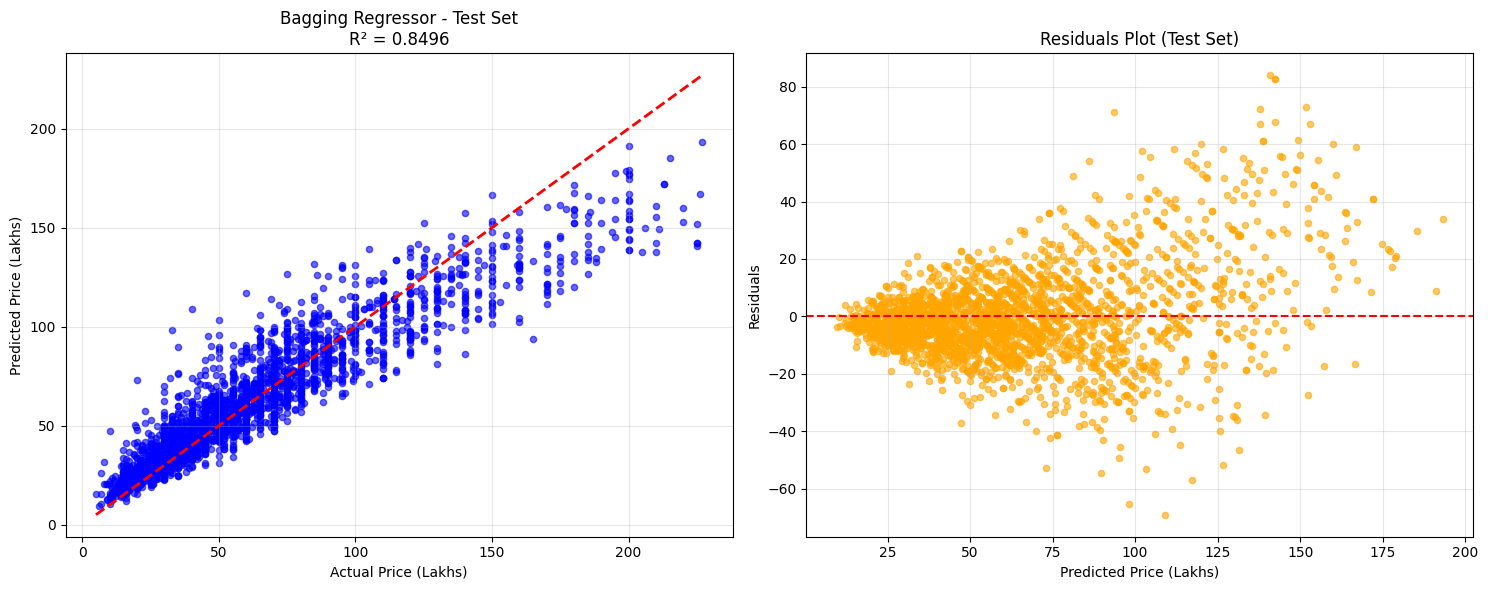


 MODEL VALIDATION COMPLETED!
   Model Performance: 85.0% R² Score


In [6]:
print(" COMPREHENSIVE MODEL EVALUATION")

X_train, X_test = X_train_global, X_test_global
y_train, y_test = y_train_global, y_test_global
data_aligned = pd.concat([X_train, X_test])
y_all = pd.concat([y_train, y_test])

print(f"   Using same train/test split from training:")
print(f"   Train samples: {len(X_train)}, Test samples: {len(X_test)}")

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

overfitting_gap = train_r2 - test_r2
overfitting_pct = (overfitting_gap / train_r2) * 100

print("    PERFORMANCE METRICS:")
print(f"   Train R²: {train_r2:.4f} ({train_r2*100:.1f}%)")
print(f"   Test R²: {test_r2:.4f} ({test_r2*100:.1f}%)")
print(f"   Overfitting Gap: {overfitting_pct:.2f}%")
print(f"   Test MAE: ₹{test_mae:.2f}L")
print(f"   Test RMSE: ₹{test_rmse:.2f}L")


print(f"\n CROSS-VALIDATION ANALYSIS:")
cv_scores = cross_val_score(pipeline, data_aligned, y_all, cv=5, scoring='r2', n_jobs=-1)
print(f"   CV R² Scores: {[f'{score:.4f}' for score in cv_scores]}")
print(f"   Mean CV R²: {cv_scores.mean():.4f}")
print(f"   CV Std Dev: {cv_scores.std():.4f}")

# Stability assessment
stability = "Excellent" if cv_scores.std() < 0.02 else "Good" if cv_scores.std() < 0.05 else "Moderate"
print(f"   Model Stability: {stability}")

# Error analysis
residuals = y_test - y_test_pred
error_pct = np.abs(residuals) / y_test * 100

print(f"\n ERROR ANALYSIS:")
print(f"   Median Absolute Error: ₹{np.median(np.abs(residuals)):.2f}L")
print(f"   Median Error %: {error_pct.median():.1f}%")
print(f"   90th Percentile Error: {np.percentile(error_pct, 90):.1f}%")
print(f"   Predictions within 15%: {(error_pct <= 15).mean()*100:.1f}%")
print(f"   Predictions within 25%: {(error_pct <= 25).mean()*100:.1f}%")

# Create performance visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Predicted vs Actual
axes[0].scatter(y_test, y_test_pred, alpha=0.6, color='blue', s=20)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price (Lakhs)')
axes[0].set_ylabel('Predicted Price (Lakhs)')
axes[0].set_title(f'Bagging Regressor - Test Set\nR² = {test_r2:.4f}')
axes[0].grid(True, alpha=0.3)

# Residuals plot
axes[1].scatter(y_test_pred, residuals, alpha=0.6, color='orange', s=20)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price (Lakhs)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residuals Plot (Test Set)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n MODEL VALIDATION COMPLETED!")
print(f"   Model Performance: {test_r2:.1%} R² Score")

## 7. Save Pipeline and Model

In [7]:
print(" SAVING PRODUCTION MODEL")

# Create models directory if it doesn't exist
models_dir = "models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f" Created directory: {models_dir}")

# Generate timestamp for model versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_version = f"v{timestamp}"

# File paths
pipeline_path = os.path.join(models_dir, f"real_estate_pipeline_{model_version}.joblib")
print(" Saving pipeline...")
joblib.dump(pipeline, pipeline_path)


# File size information
pipeline_size = os.path.getsize(pipeline_path) / (1024*1024)  # MB

print(f" MODEL SAVED SUCCESSFULLY!")
print(f"   Pipeline: {pipeline_path} ({pipeline_size:.2f} MB)")
print(f"   Version: {model_version}")
print(f"   Performance: {test_r2:.1%} R² Score")

# Verify saved files
print(f"\n VERIFICATION:")
print(f"   Files exist: {os.path.exists(pipeline_path)}")

# Quick load test
try:
    loaded_pipeline = joblib.load(pipeline_path)
    print(f"   Load test:  Success")
    print(f"   Pipeline type: {type(loaded_pipeline).__name__}")
    print(f"   Model type: {type(loaded_pipeline.named_steps['model']).__name__}")
except Exception as e:
    print(f"   Load test:  Failed - {e}")


 SAVING PRODUCTION MODEL
 Saving pipeline...
 MODEL SAVED SUCCESSFULLY!
   Pipeline: models\real_estate_pipeline_v20250915_182141.joblib (3.73 MB)
   Version: v20250915_182141
   Performance: 85.0% R² Score

 VERIFICATION:
   Files exist: True
   Load test:  Success
   Pipeline type: Pipeline
   Model type: BaggingRegressor
